In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import SmoothBivariateSpline, interp2d, griddata, RegularGridInterpolator, RectBivariateSpline

import lbwsg
import test_lbwsg

!date
!whoami

Tue Mar 16 12:42:32 PDT 2021
ndbs


# Load category data

In [2]:
cat_df = lbwsg.get_category_data()
cat_df.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lbwsg_category,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga,ga_width,ga_midpoint,bw,bw_width,bw_midpoint
0,cat2,10755,"Birth prevalence - [0, 24) wks, [0, 500) g",0,24,0,500,"[0, 24)",24,12.0,"[0, 500)",500,250.0
1,cat8,10761,"Birth prevalence - [0, 24) wks, [500, 1000) g",0,24,500,1000,"[0, 24)",24,12.0,"[500, 1000)",500,750.0
2,cat10,10763,"Birth prevalence - [24, 26) wks, [500, 1000) g",24,26,500,1000,"[24, 26)",2,25.0,"[500, 1000)",500,750.0
3,cat11,10764,"Birth prevalence - [26, 28) wks, [500, 1000) g",26,28,500,1000,"[26, 28)",2,27.0,"[500, 1000)",500,750.0
4,cat14,10767,"Birth prevalence - [30, 32) wks, [500, 1000) g",30,32,500,1000,"[30, 32)",2,31.0,"[500, 1000)",500,750.0


# Try creating a meshgrid for plotting

https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html

In [3]:
ga_mid = cat_df['ga_midpoint']
bw_mid = cat_df['bw_midpoint']

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
ga_range = ga_mid.unique()
ga_range.sort()
ga_range

array([12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ])

In [5]:
bw_range = bw_mid.unique()
bw_range.sort()
bw_range

array([ 250.,  750., 1250., 1750., 2250., 2750., 3250., 3750., 4250.])

In [6]:
midpoint_grid_coordinates = np.meshgrid(ga_range, bw_range)
midpoint_grid_coordinates

[array([[12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ]]),
 array([[ 250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,
          250.,  250.],
        [ 750.,  750.,  750.,  750.,  750.,  750.,  750.,  750.,  750.,
          750.,  750.],
        [1250., 1250., 1250., 1250., 1250., 1250., 1250., 1250., 1250.,
         1250., 1250.],
        [1750., 1750., 175

In [7]:
gridx, gridy = midpoint_grid_coordinates

# Load RR data

In [8]:
filename = 'lbwsg_data.hdf'
rr = pd.read_hdf(filename, '/gbd_2019/relative_risk/diarrheal_diseases')
print(rr.shape)

(232, 1012)


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


# Map RR's to intervals and grid points

In [9]:
rr_by_cat = lbwsg.get_relative_risk_set_by_category(rr)
rr_by_cat.head()

lbwsg_category
cat2     943.601981
cat8     769.060023
cat10    494.876186
cat11    241.935671
cat14    131.813491
Name: relative_risk, dtype: float64

In [10]:
rr_by_interval = cat_df.set_index(['ga', 'bw'])['lbwsg_category'].map(rr_by_cat)
rr_by_interval.head()

ga        bw         
[0, 24)   [0, 500)       943.601981
          [500, 1000)    769.060023
[24, 26)  [500, 1000)    494.876186
[26, 28)  [500, 1000)    241.935671
[30, 32)  [500, 1000)    131.813491
Name: lbwsg_category, dtype: float64

In [11]:
rrs_for_grid = cat_df.set_index(['ga_midpoint', 'bw_midpoint'])['lbwsg_category'].map(rr_by_cat)
rrs_for_grid.head()

ga_midpoint  bw_midpoint
12.0         250.0          943.601981
             750.0          769.060023
25.0         750.0          494.876186
27.0         750.0          241.935671
31.0         750.0          131.813491
Name: lbwsg_category, dtype: float64

# Get z values at grid midpoints, and plot a heatmap using `plt.imshow`

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

## Looks kind of cool, but it draws an evenly spaced grid, which is not ideal...

In [12]:
gridx[0]

array([12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ])

In [13]:
gridy[0]

array([250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.])

In [14]:
list(zip(gridx[0], gridy[0]))

[(12.0, 250.0),
 (25.0, 250.0),
 (27.0, 250.0),
 (29.0, 250.0),
 (31.0, 250.0),
 (33.0, 250.0),
 (35.0, 250.0),
 (36.5, 250.0),
 (37.5, 250.0),
 (39.0, 250.0),
 (41.0, 250.0)]

In [15]:
rrs_for_grid.reindex(list(zip(gridx[0], gridy[0])))

ga_midpoint  bw_midpoint
12.0         250.0          943.601981
25.0         250.0                 NaN
27.0         250.0                 NaN
29.0         250.0                 NaN
31.0         250.0                 NaN
33.0         250.0                 NaN
35.0         250.0                 NaN
36.5         250.0                 NaN
37.5         250.0                 NaN
39.0         250.0                 NaN
41.0         250.0                 NaN
Name: lbwsg_category, dtype: float64

In [16]:
rrs_for_grid.reindex(list(zip(gridx[1], gridy[1])))

ga_midpoint  bw_midpoint
12.0         750.0          769.060023
25.0         750.0          494.876186
27.0         750.0          241.935671
29.0         750.0          161.819728
31.0         750.0          131.813491
33.0         750.0                 NaN
35.0         750.0                 NaN
36.5         750.0                 NaN
37.5         750.0                 NaN
39.0         750.0                 NaN
41.0         750.0                 NaN
Name: lbwsg_category, dtype: float64

In [17]:
gridz = np.array([rrs_for_grid.reindex(list(zip(gridx[i], gridy[i]))) for i in range(len(gridx))])
gridz

array([[943.60198121,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan],
       [769.06002253, 494.87618597, 241.93567075, 161.81972782,
        131.81349081,          nan,          nan,          nan,
                 nan,          nan,          nan],
       [         nan,          nan, 151.69857921,  76.61568899,
         88.7669448 ,  53.3891477 , 105.28683558,  88.77993745,
         76.62675935, 103.58653725,          nan],
       [         nan,          nan,          nan,  59.13225136,
         47.86588928,  30.79151232,  29.79433124,  44.78476548,
         36.11132985,  38.36099369,  35.19201703],
       [         nan,          nan,          nan,  96.64554121,
         34.7885274 ,  25.36261891,  16.53789424,   5.86826095,
          7.00971825,   8.731903  ,   7.0986533 ],
       [         nan,          nan,          nan,  35.58178734,
         30.50918543,  19.38928358,   5.7

## Heat map of raw relative risks -- range is too large to see detail

Also, the units on the axes are wrong.

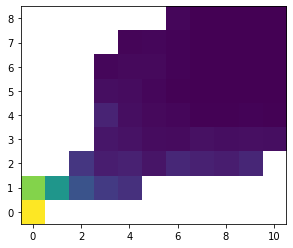

In [18]:
plt.imshow(gridz, origin='lower')

## Heat map of log RR's -- that looks better, but points are evenly spaced, which is misleading

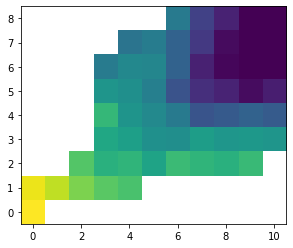

In [19]:
plt.imshow(np.log(gridz), origin='lower')

In [20]:
gridlogz = np.log(gridz)

# Draw a contour plot!

Using the following as an example for all the plots below:

https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html

## This contour plot uses only the raw data -- any interpolation is being automaticaly done by `matplotlib`

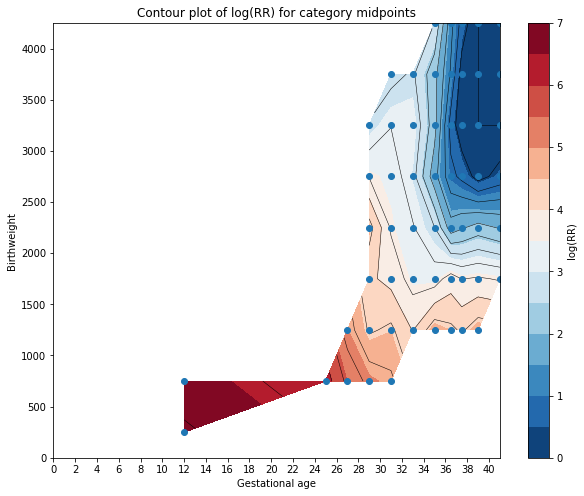

In [21]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(ga_mid, bw_mid, 'o')

ax.contour(gridx, gridy, gridlogz, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(gridx, gridy, gridlogz, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax, label='log(RR)')

ax.set_xticks(range(0,42,2))
ax.set_yticks(range(0,4500,500))
ax.set_xlabel('Gestational age')
ax.set_ylabel('Birthweight')
ax.set_title("Contour plot of log(RR) for category midpoints")
plt.show()

# Plot linear interpolation using `griddata`

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata

### This seems like it would be a reasonable way to interpolate the RR's, except that the estimates are confined to the convex hull of the data points, which misses points near the boundary of the [0,42]x[0,4500] GAxBW rectangle that we need.

To generate grid points on which `griddata` can calculate interpolated values, use `numpy`'s `mgrid` function, which is similar to `meshgrid` above:

https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html

http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/

In [22]:
x, y = ga_mid, bw_mid
z = rrs_for_grid
logz = np.log(z)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Create a grid of xi and yi values to interpolate on so we can draw the function on the whole rectangle
xi, yi = np.mgrid[0:42:100j, 0:4500:200j]
# Interpolate log(z) from category midpoints (x,y) to the grid points (xi,yi) using scipy's griddata function
logzi_linear = griddata((x, y), logz, (xi, yi), method='linear', rescale=False)

In [24]:
xi.shape

(100, 200)

In [25]:
yi.shape

(100, 200)

In [26]:
logzi_linear.shape

(100, 200)

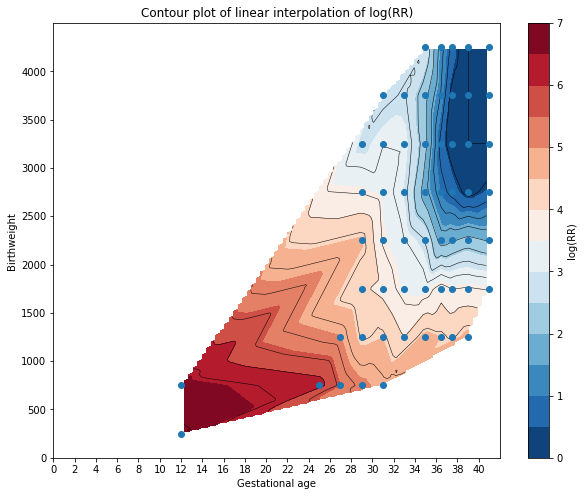

In [27]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x, y, 'o')

ax.contour(xi, yi, logzi_linear, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(xi, yi, logzi_linear, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax, label='log(RR)')

ax.set_xticks(range(0,42,2))
ax.set_yticks(range(0,4500,500))
ax.set_xlabel('Gestational age')
ax.set_ylabel('Birthweight')
ax.set_title("Contour plot of linear interpolation of log(RR)")
plt.show()

### Rescaling to unit cube before interpolating makes linear interpolation a little smoother, since BW and GA scales are so different

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


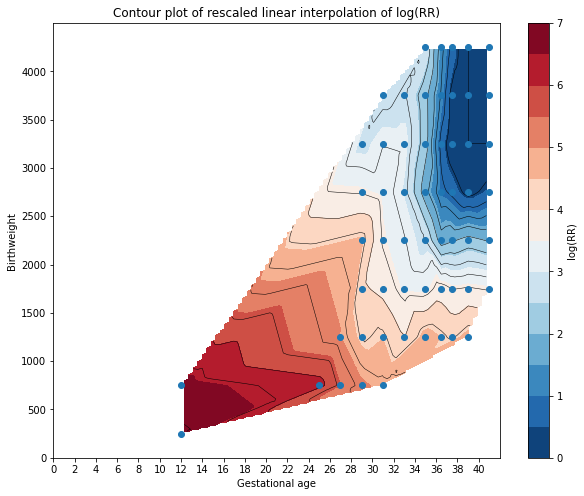

In [28]:
xi, yi = np.mgrid[0:42:100j, 0:4500:200j]
logzi_linear_rescaled = griddata((x, y), logz, (xi, yi), method='linear', rescale=True)

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x, y, 'o')

ax.contour(xi, yi, logzi_linear_rescaled, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(xi, yi, logzi_linear_rescaled, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax, label='log(RR)')

ax.set_xticks(range(0,42,2))
ax.set_yticks(range(0,4500,500))
ax.set_xlabel('Gestational age')
ax.set_ylabel('Birthweight')
ax.set_title("Contour plot of rescaled linear interpolation of log(RR)")
plt.show()

# Plot nearest neighbor interpolation using `griddata` without rescaling

### It looks like we could use this to fill in missing grid values before using `RectBivariateSpline` -- woo hoo!

In [29]:
logzi_nearest = griddata((x, y), logz, (xi, yi), method='nearest', rescale=False)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
%timeit griddata((x, y), logz, (xi, yi), method='nearest', rescale=False)

43.4 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


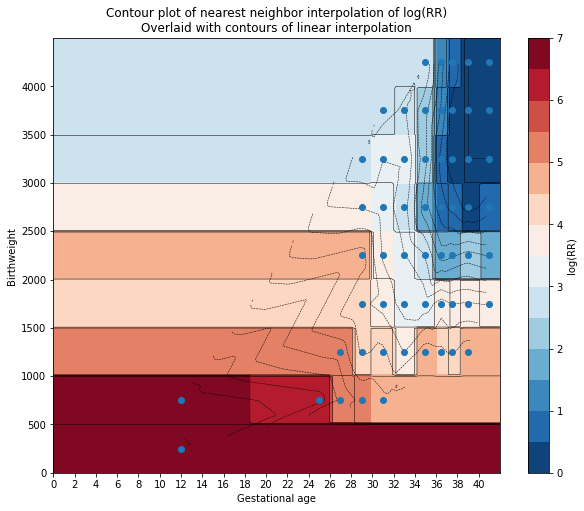

In [31]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x, y, 'o')

ax.contour(xi, yi, logzi_linear, levels=20, linewidths=0.5, colors='k', linestyles='--')
ax.contour(xi, yi, logzi_nearest, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(xi, yi, logzi_nearest, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax, label='log(RR)')

ax.set_xticks(range(0,42,2))
ax.set_yticks(range(0,4500,500))
ax.set_xlabel('Gestational age')
ax.set_ylabel('Birthweight')
ax.set_title("Contour plot of nearest neighbor interpolation of log(RR)"
             "\nOverlaid with contours of linear interpolation"
            )
plt.show()

In [32]:
len(np.unique(logzi_nearest))

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


53

In [33]:
rr_by_cat.nunique()

53

# What happens if we rescale?

# Plot nearest neighbor interpolation using `griddata` with rescaling

### Perhaps this is more reasonable, perhaps not... the unscaled version looks smoother, so that's probably better for bootstrapping the bilinear interpolation without causing unwanted fluctuations

In [34]:
logzi_nearest_rescaled = griddata((x, y), logz, (xi, yi), method='nearest', rescale=True)

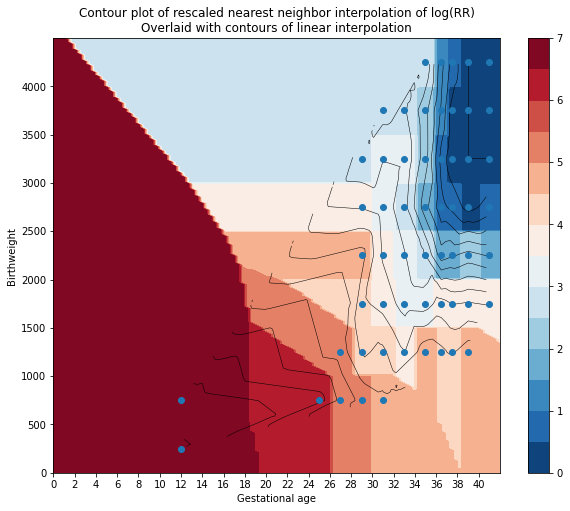

In [35]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x, y, 'o')

ax.contour(xi, yi, logzi_linear_rescaled, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(xi, yi, logzi_nearest_rescaled, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)

ax.set_xticks(range(0,42,2))
ax.set_yticks(range(0,4500,500))
ax.set_xlabel('Gestational age')
ax.set_ylabel('Birthweight')
ax.set_title("Contour plot of rescaled nearest neighbor interpolation of log(RR)"
             "\nOverlaid with contours of linear interpolation"
            )
plt.show()

# Try cubic interpolation using `griddata`

## This is called overfitting... No good.

In [36]:
logzi_cubic = griddata((x, y), logz, (xi, yi), method='cubic', rescale=False)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


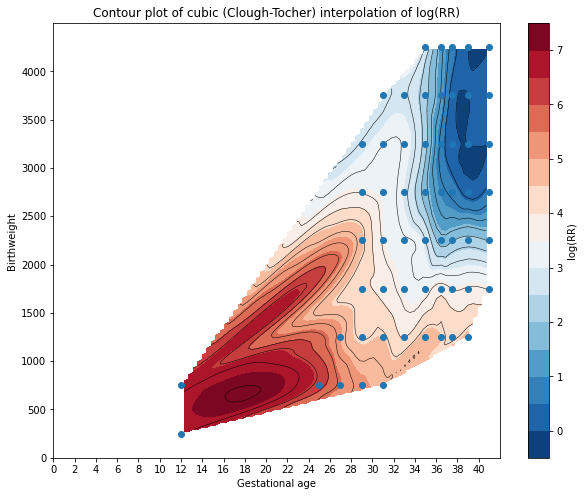

In [37]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x, y, 'o')

ax.contour(xi, yi, logzi_cubic, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(xi, yi, logzi_cubic, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax, label='log(RR)')

ax.set_xticks(range(0,42,2))
ax.set_yticks(range(0,4500,500))
ax.set_xlabel('Gestational age')
ax.set_ylabel('Birthweight')
ax.set_title("Contour plot of cubic (Clough-Tocher) interpolation of log(RR)")
plt.show()

In [38]:
np.asarray([3,4,5]).reshape((1,1,3))

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[3, 4, 5]]])